# Topic Modelling of Amazon Movie Reviews - using spaCy scikit-learn Latent Dirichlet Allocation (LDA) Model. 
 By Heidi Nguyen

<a id="top"></a>

# Table of Contents 

- [I. Data Exploration](#data)

- [II. Latent Dirichlet Allocation](#LDA)

- [III. pyLDAvis - Interactive Topic Model Visualization. ](#viz)

- [IV. **Summary of Results**](#resultFinal)

- [V. Reference](#ref)


In [349]:
from __future__ import unicode_literals
# libraries
from pandas import DataFrame,Series
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from collections import Counter
import os # to set wd # # os.environ['KERAS_BACKEND']='tensorflow' for keras
import re

# get time stamp
import time
# import Image
from IPython.display import Image

# sklearn
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus


# access keyboard shortcuts: Esc + H
# Mac: Cmd + Shift + P ==> private browsing => Firefox does not track 
# Linux and Windows: or Ctrl + Shift + P on Linux and Windows

# Set wd
path = "/Volumes/NO NAME/Data Science/2018-0826 MSDS 7337 Natural Language Processing/Unit 15/Final"
os.chdir(path)
print (os.getcwd()); # Prints the working directory


/Volumes/NO NAME/Data Science/2018-0826 MSDS 7337 Natural Language Processing/Unit 15/Final


## Software Used

In [436]:
#environment and package versions
print('\n')
print("_"*70)
print('The environment and package versions used in this script are:')
print('\n')

import platform; print(platform.platform())
import sys; print("python", sys.version)
import IPython; print("IPython version:", IPython.__version__)
import numpy; print("numpy", numpy.__version__)
import scipy; print("scipy", scipy.__version__)
import 65 print("Scikit-learn", sklearn.__version__)
import pandas; print("Pandas", pandas.__version__)
import bokeh; print("bokeh", bokeh.__version__)
import seaborn as sns; print("seaborn", sns.__version__)
import matplotlib ; print("matplotlib", matplotlib.__version__)
import plotly; print('plotly', plotly.__version__)
import spacy; print("spacy", spacy.__version__)
import nltk; print("nltk", nltk.__version__)
# import yellowbrick; print("yellowbrick", yellowbrick.__version__)
import gensim; print("gensim", gensim.__version__)
# import mglearn; print("mglearn", mglearn.__version__)
import re; print("re", re.__version__)
import pattern; print("pattern", pattern.__version__)
# print (os.environ['CONDA_DEFAULT_ENV'])
import pyLDAvis ; print("pyLDAvis", pyLDAvis.__version__)
import ipywidgets; print("ipywidgets", ipywidgets.__version__)

print ("Anaconda Python Environment is: py27")

print('\n')
print("~"*70)
print('\n')



______________________________________________________________________
The environment and package versions used in this script are:


Darwin-18.0.0-x86_64-i386-64bit
(u'python', '2.7.14 |Anaconda custom (64-bit)| (default, Mar 27 2018, 12:28:59) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]')
(u'IPython version:', '5.7.0')
(u'numpy', '1.14.5')
(u'scipy', '1.1.0')
(u'Scikit-learn', '0.19.1')
(u'Pandas', u'0.23.3')
(u'bokeh', u'0.13.0')
(u'seaborn', '0.9.0')
(u'matplotlib', '2.2.3')
(u'plotly', '3.4.2')
(u'spacy', '2.0.12')
(u'nltk', '3.3')
(u'gensim', '3.4.0')
(u're', '2.2.1')
(u'pattern', '2.4')
(u'pyLDAvis', '2.1.2')
(u'ipywidgets', '7.3.0')
Anaconda Python Environment is: py27


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




<a id="analyzer"></a>

# Topics Modelling: 
    1) This notebook presents topic modeling on Amazon Good and Bad Movie Reviews using LDA for Topic Modeling analysis. This is because of my relatively large corpus. I then create data visualization, using pyLDAvis and matplotlib, as evidence to prove my hypothesis/use-case. 
    2) The purpose of this project is to investigate what are the sentiments in movie reviews that are good reviews and what are the issues in those bad reviews.
    Hypothesis: There are positive relation between good reviews with positive words and high ratings of the reviews. 
 
 <a href="#top">Back to top</a>

<a id="data"></a>

# I. Data Exploration

 <a href="#top">Back to top</a>

In [352]:
# coding: utf-8
# load movie reviews  
movie_data_all = pd.read_csv(r'reviews_movies_nodup_wTitle_clean4000_20181112-144157.csv') # must read in as r' if does not have encoding='utf-8'
movie_data_all.head()

# dataset = pd.read_csv(r'E:/aclImdb/movie_reviews.csv')
# # print sample data
# In [235]: print dataset.head()

,product_desc,body
0,Woman Walks Ahead,"Very good movie, sad tho as to what the white ..."
1,Woman Walks Ahead,I loved this film. True story about Sitting B...
2,Woman Walks Ahead,Excellent
3,Woman Walks Ahead,Good movie.
4,Woman Walks Ahead,True life happenings terrible for what happen...


In [437]:
# remame column names
movie_data_all = movie_data_all.rename(index=str, columns={"product_desc": "title", "body": "reviews"})
movie_data_all.head()
movie_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14087 entries, 0 to 14086
Data columns (total 2 columns):
title      14087 non-null object
reviews    14087 non-null object
dtypes: object(2)
memory usage: 330.2+ KB


In [500]:
# get a random subset without replacement
movie_data = movie_data_all.sample(n=14087)
movie_data.info()
movie_data.head()
# movie_data_all['reviews'][0]

<class 'pandas.core.frame.DataFrame'>
Index: 14087 entries, 10538 to 10773
Data columns (total 2 columns):
title      14087 non-null object
reviews    14087 non-null object
dtypes: object(2)
memory usage: 330.2+ KB


,title,reviews
10538,Sicario: Day Of The Soldado,this one feels disconnected . too much watchin...
10382,Jumanji: Welcome To The Jungle,Everyone in the family enjoys and laughs
6423,Galaxy Quest,I love this Movie. It is non-stop laughs. If...
6416,Harry Brown,He def knows how to take matters into his own ...
10049,Escape Plan 2: Hades,I just wish they had concluded properly by fin...


In [501]:
# get the np arrays of title and reviews 
movie_titles = np.array(movie_data['title'])
movie_reviews = np.array(movie_data['reviews'])


In [502]:
# print sample movie and its synopsis
print 'Movie:', movie_titles[49]
print 'Movie Review:', movie_reviews[49][:1000]


Movie: Jumanji: Welcome To The Jungle
Movie Review: My grandkids loved the movie.  Pretty funny!


In [543]:
# Number of unique movie
len(movie_data.title.unique())

16

In [550]:
cat_grouped

reviews         \
                                               count unique   
title                                                         
A Fistful of Dollars                             311    311   
Ant-Man and the Wasp                             118    118   
Escape Plan 2: Hades                             350    350   
From Paris with Love                             521    521   
Galaxy Quest                                    2582   2582   
Get Smart                                        606    606   
Gringo                                           378    378   
Harry Brown                                      269    269   
Into the Blue (2005)                            1158   1158   
Jumanji: Welcome To The Jungle                  2936   2936   
Legend                                          1372   1372   
Sicario: Day Of The Soldado                      254    254   
Smokey and the Bandit                            951    951   
Solo: A Star Wars Story (Theatrical Version)     677    677   
Transformers: The Last Knight                   1289   1289   
Woman Walks Ahead                                315    315   

                                                                                                 \
                                                                                            top   
title                                                                                             
A Fistful of Dollars                          It is difficult now to realize what a very, ve...   
Ant-Man and the Wasp                                                               Great movie.   
Escape Plan 2: Hades                                                                it was okay   
From Paris with Love                                                               Great movie.   
Galaxy Quest                                                                one of my favorites   
Get Smart                                     A family favorite.  Perfectly cast and perfect...   
Gringo                                                               Didn't like anything.  No.   
Harry Brown                                                                        Great movie.   
Into the Blue (2005)                          I enjoyed this alluring film.I found it to be ...   
Jumanji: Welcome To The Jungle                My teenage son and I loved this movie. I am us...   
Legend                                        Girlfriend said she wanted unicorns and ferrie...   
Sicario: Day Of The Soldado                   Not bad but leaves you hanging. Wait till the ...   
Smokey and the Bandit                         Classic movie. Jackie Gleason steals the show....   
Solo: A Star Wars Story (Theatrical Version)                                       Great movie.   
Transformers: The Last Knight                 These movies were never known for their grippi...   
Woman Walks Ahead                             We didn't even finish the movie, and we love W...   

                                                   
                                             freq  
title                                              
A Fistful of Dollars                            1  
Ant-Man and the Wasp                            1  
Escape Plan 2: Hades                            1  
From Paris with Love                            1  
Galaxy Quest                                    1  
Get Smart                                       1  
Gringo                                          1  
Harry Brown                                     1  
Into the Blue (2005)                            1  
Jumanji: Welcome To The Jungle                  1  
Legend                                          1  
Sicario: Day Of The Soldado                     1  
Smokey and the Bandit                           1  
Solo: A Star Wars Story (Theatrical Version)    1  
Transformers: The Last Knight                   1  
Woman Walks Ahead            

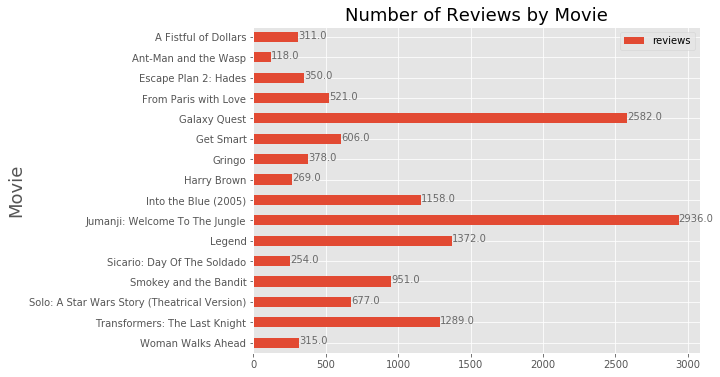

In [561]:
plt.rcParams['figure.figsize']=(8,6) #set the figure size 
# fig, ax = plt.subplots(1,1, sharey=True)

plt.style.use('ggplot')
cat_rate_grouped = movie_data.groupby('title').count() #.plot(kind='bar')
ax = cat_rate_grouped.plot(kind='barh')

# ax.set_alpha(0.8)
ax.set_title("Number of Reviews by Movie", fontsize=18)
ax.set_ylabel("Movie", fontsize=18);
# #List unique values in the df['category'] column 
# ax.set_yticks(dfjl_asin_dropna.category.unique())

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2)), fontsize=10, color='dimgrey')

# invert for largest on top 
ax.invert_yaxis()

There are 16 movies, 14k reviews. Most of movies have less than 600 reviews. The distibution of the number of reviews are not even across the 16 movies. 

In [564]:
movie_data.head()

,title,reviews
10538,Sicario: Day Of The Soldado,this one feels disconnected . too much watchin...
10382,Jumanji: Welcome To The Jungle,Everyone in the family enjoys and laughs
6423,Galaxy Quest,I love this Movie. It is non-stop laughs. If...
6416,Harry Brown,He def knows how to take matters into his own ...
10049,Escape Plan 2: Hades,I just wish they had concluded properly by fin...


In [566]:
# review length
movie_data['length_reviews']=movie_data.reviews.str.len()
movie_data.head() 

,title,reviews,length_reviews
10538,Sicario: Day Of The Soldado,this one feels disconnected . too much watchin...,81
10382,Jumanji: Welcome To The Jungle,Everyone in the family enjoys and laughs,40
6423,Galaxy Quest,I love this Movie. It is non-stop laughs. If...,148
6416,Harry Brown,He def knows how to take matters into his own ...,139
10049,Escape Plan 2: Hades,I just wish they had concluded properly by fin...,177


Text(0.5,1,u'Review Length per Movie')

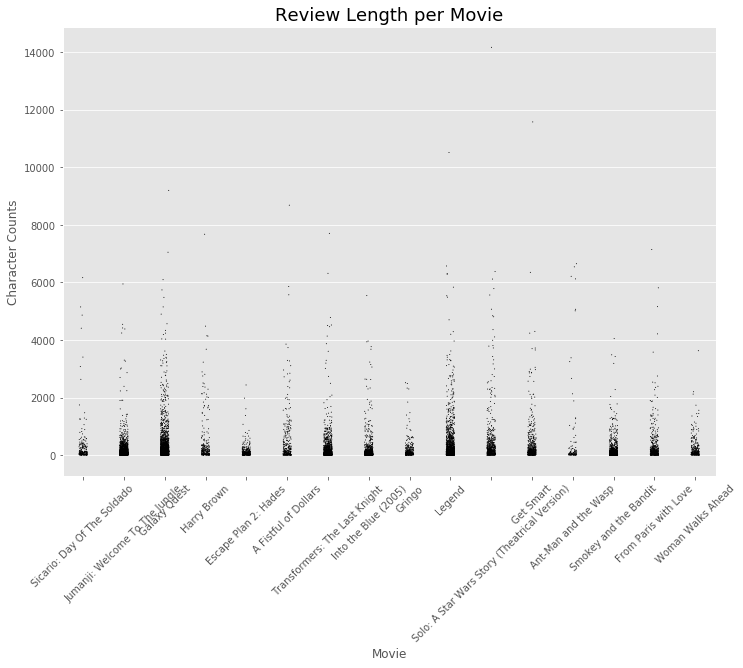

In [575]:
# Length of reviews ~ rating

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

# Stripplot -Draw a scatterplot where one variable is categorical.
sns.stripplot(x=movie_data.title, y=movie_data.length_reviews, jitter=True, size=1, color='black')

plt.xlabel("Movie")
plt.xticks(rotation=45) # rotate the movie name 45degree
plt.ylabel("Character Counts")
plt.title("Review Length per Movie", fontsize=18)


# Conclusion: as expected some correlation between satisfaction and prolixity

The length of each review is mostly less than 1000 characters long. 



### Normalization and Data Pre-preprocessing

    Remove stopwords 
    Remove punctuations
    Lemmatize to reduce related forms of a word to a common base

 <a href="#top">Back to top</a>
 

In [503]:
%%time 
# coding: utf-8
# perform normalization. 
from normalization_hn import normalize_corpus, normalize_accented_characters, strip_html, html_parser, pos_tag_text

# function in normalization_hn module: normalize_corpus(movie_reviews,lemmatize=True,only_text_chars=True,tokenize=False)
# Topic Modelling -- for gensim we need to tokenize the data and filter out stopwords 
norm_tokenized_corpus = normalize_corpus(movie_reviews, tokenize=True) # lemmatize=True by default

CPU times: user 3min 20s, sys: 3.67 s, total: 3min 24s
Wall time: 3min 25s


In [598]:
norm_tokenized_corpus

[[u'feel',
  u'disconnect',
  u'much',
  u'watching',
  u'helicopter',
  u'fly',
  u'instead',
  u'story'],
 [u'everyone', u'family', u'enjoy', u'laugh'],
 [u'love',
  u'movie',
  u'non',
  u'stop',
  u'laugh',
  u'sci',
  u'fi',
  u'fan',
  u'star',
  u'trek',
  u'particular',
  u'like',
  u'good',
  u'spoof',
  u'movie'],
 [u'def',
  u'know',
  u'take',
  u'matter',
  u'hand',
  u'show',
  u'young',
  u'kid',
  u'respect',
  u'community',
  u'elder',
  u'5stars',
  u'movie'],
 [u'wish',
  u'conclude',
  u'properly',
  u'dispose',
  u'organization',
  u'behind',
  u'prison',
  u'perhaps',
  u'not',
  u'keep',
  u'door',
  u'open',
  u'another',
  u'escape',
  u'plan',
  u'movie'],
 [u'enjoy', u'movie', u'love', u'fight', u'scene'],
 [u'great',
  u'antihero',
  u'story',
  u'transcend',
  u'usual',
  u'boring',
  u'western',
  u'formula'],
 [u'kid',
  u'excite',
  u'movie',
  u'disappoint',
  u'dish',
  u'wont',
  u'play',
  u'3',
  u'player',
  u'finally',
  u'rent',
  u'redbox',
  u'

### TF-IDF Based Feature Extraction

Keep text tokens in the normalized text and extract TF-IDF–based unigrams features.

In [ ]:
movie_data

In [600]:
# Baseline: number of unique tokens
# for feature extraction later
from utils import build_feature_matrix

# vectorizer = CountVectorizer() # default: binary=False
# Keep text tokens in the normalized text and extract TF-IDF–based features only unigrams
# such that each feature occurs in at least in 0 percent of the documents and at most 50 percent of the documents using the terms min_df and max_df. 
# Using thresholds to reduce the number of tokens
vectorizer = TfidfVectorizer(min_df=0, max_df=.5, ngram_range=(1, 1)) # unigrams, min_df=0, max_df=.5,

# # get the np arrays of title and reviews 
# movie_titles = np.array(movie_data['title'])
# movie_reviews = np.array(movie_data['reviews'])

doc_term_matrix = vectorizer.fit_transform(movie_reviews) # norm_tokenized_corpus, movie_data.reviews, movie_reviews
doc_term_matrix

# Compute relative term frequency -- Binary
# vectorizer = CountVectorizer(binary=True)


<14087x21365 sparse matrix of type '<type 'numpy.float64'>'
	with 433554 stored elements in Compressed Sparse Row format>

In [601]:
doc_term_matrix.shape

(14087, 21365)

In [602]:
# Inspect tokens
# vectorizer keeps words
words = vectorizer.get_feature_names()
words[:10]

[u'00', u'000', u'007', u'01', u'02', u'02am', u'03', u'05', u'06', u'07']

In [603]:
# Inspect doc-term matrix
# from scipy compressed sparse row matrix to sparse DataFrame
doc_term_matrix_df = pd.SparseDataFrame(doc_term_matrix, columns=words)
doc_term_matrix_df.head()

,00,000,007,01,02,02am,03,05,06,07,...,zuccarini,zuccoti,zulu,zuul,zweers,zz,zzz,zzzz,ça,être
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [604]:
# Most frequent terms before removing stopwords
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head() 

it       876
and      784
this     661
great    628
of       615
dtype: int64

In [511]:
words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)

# reduce to 1D array
word_freq_1d = np.squeeze(np.asarray(word_freq))

pd.Series(word_freq_1d, index=words).div(
    movie_data.shape[0]).sort_values(ascending=False).head(10)

it      0.06
and     0.06
this    0.05
great   0.04
of      0.04
to      0.04
is      0.04
good    0.04
was     0.04
funny   0.03
dtype: float64

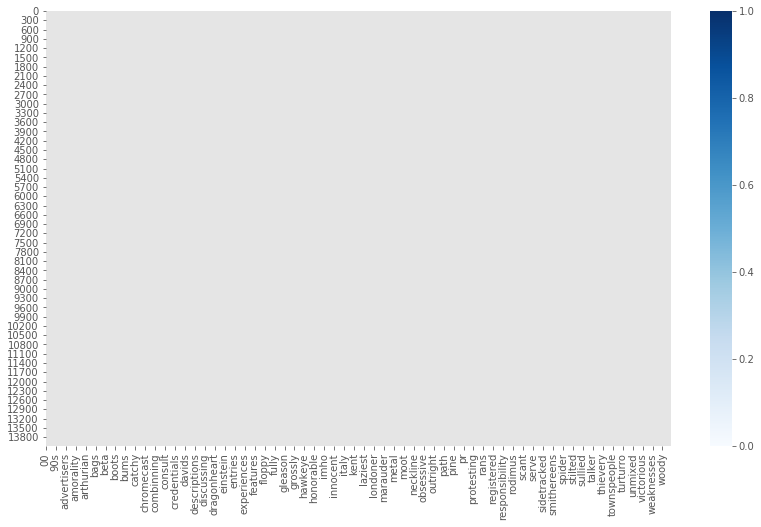

In [512]:
# Visualize Doc-Term Matrix for all reviews
sns.heatmap(pd.DataFrame(doc_term_matrix.todense(), columns=words), cmap='Blues')
plt.gcf().set_size_inches(14, 8);

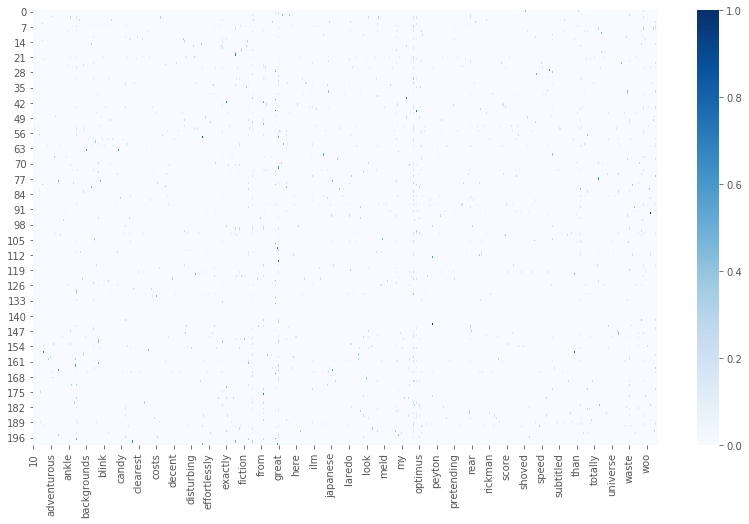

In [583]:
# Visualize Doc-Term Matrix for 200 sample reviews

vectorizer_s = TfidfVectorizer(min_df=0, max_df=.5, # 
                                     ngram_range=(1, 1)) # unigrams. Default tfidf = TfidfVectorizer()

doc_term_matrix_s = vectorizer_s.fit_transform(movie_data.reviews.sample(200))
doc_term_matrix_s.shape

words_s = vectorizer_s.get_feature_names()
word_freq_s = doc_term_matrix_s.sum(axis=0)

# reduce to 1D array
word_freq_1d_s = np.squeeze(np.asarray(word_freq_s))

# Visualize Doc-Term Matrix for 200 samples
sns.heatmap(pd.DataFrame(doc_term_matrix_s.todense(), columns=words_s), cmap='Blues') # cmap='Blues'
plt.gcf().set_size_inches(14, 8);

<a id="LDA"></a>

# II. Latent Dirichlet Allocation Model

The latent Dirichlet allocation (LDA) technique is a generative probabilistic model where each document is assumed to have a combination of topics similar to a probabilistic latent semantic indexing model—but in this case, the latent topics contain a Dirichlet prior over them.

The following steps give a very simplistic explanation of what happens in the algorithm to extract K topics from the documents:
    1. Initialize the necessary parameters.
    2. For each document, randomly initialize each word to one of
    the K topics.
    3. Start an iterative process as follows and repeat it several times.
    4. For each document D:
        a. For each word W in document:
            • For each topic T:
                • Compute P (T | D ) , which is proportion of words in D assigned to topic T.
                • Compute P (W |T ) , which is proportion of assignments to topic T over all documents having
                the word W.
            • Reassign word W with topic T with probability
            P (T | D ) ́ P (W | T ) considering all other words and their topic assignments.

LDA is an iterative algorithm. Here are the two main steps:

    In the initialization stage, each word is assigned to a random topic.
    Iteratively, the algorithm goes through each word and reassigns the word to a topic taking into consideration:
        What’s the probability of the word belonging to a topic
        What’s the probability of the document to be generated by a topic

Once this runs for several iterations, there should be topic mixtures for each document and then generate the constituents of each topic from the terms that point to that topic. 

 <a href="#top">Back to top</a>
 

## Latent Dirichlet Allocation (gensim) Model
    
    i. Parameters of LDA

    num_topics: specify how many topics to extract from the documents
    alpha: document-topic density where greater it is, the article will be assigned to more topics. 
    eta: topic-word density where the greater it is, more words contained in each topic.

After a few trials with various model parameters in the LdaModel class to find that the best model is with number of topic of 10. Alpha and eta are set as default. 

    ii. The LDA result can be interpreted as a distribution over topics.


 <a href="#top">Back to top</a>

In [605]:
# We use gensim in the following implementation to build a topic model:
from gensim import corpora, models

def train_lda_model_gensim(corpus, total_topics=2):
    # normalize corpus
    # For gensim we need to tokenize the data and filter out stopwords
    norm_tokenized_corpus = normalize_corpus(corpus, tokenize=True)
    # Build the dictionary - association word to numeric id
    dictionary = corpora.Dictionary(norm_tokenized_corpus)  # view the dictionary mappings: print dictionary.token2id
    # convert tokenized documents into bag of words vectors or to transform the collection of texts to a numerical form
    mapped_corpus = [dictionary.doc2bow(text)
                     for text in norm_tokenized_corpus] 
    # view the converted vectorized corpus: mapped_corpus[20] (20th document looks like: [(word_id, count), ...])
#     print (mapped_corpus[20]) # [(14, 1), (19, 2), (185, 1), (218, 1)]

    # build tf-idf feature vectors
    tfidf = models.TfidfModel(mapped_corpus)
    corpus_tfidf = tfidf[mapped_corpus]
    # Build the LDA model
    lda = models.LdaModel(corpus_tfidf, 
                          id2word=dictionary,
                          iterations=1000,
                          num_topics=total_topics)
    return lda


In [606]:
# The following function helps display the topics in a better way with or without thresholds:
def print_topics_gensim(topic_model, total_topics=1,
                        weight_threshold=0.0001,
                        display_weights=False,
                        num_terms=None):
    for index in range(total_topics):
        topic = topic_model.show_topic(index)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]
        if display_weights:
            print 'Topic #'+str(index+1)+' with weights'
            print topic[:num_terms] if num_terms else topic
        else:
            print 'Topic #'+str(index+1)+' without weights'
            tw = [term for term, wt in topic]
            print tw[:num_terms] if num_terms else tw
    print

Below ae utility functions that generate these topics by connecting the terms with their weights and then printing these topics using a function with configurable parameters.


In [515]:
# get topics with their terms and weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1])
                                for row 
                               in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) 
                               for wt, index
                               in zip(weights,sorted_indices)])
    sorted_terms = np.array([list(feature_names[row])
                             for row
                             in sorted_indices])
    topics = [np.vstack((terms.T,
                     term_weights.T)).T
              for terms, term_weights
              in zip(sorted_terms, sorted_weights)]
    return topics


In [516]:
# print all the topics from a corpus
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]
        if display_weights:
            print 'Topic #'+str(index+1)+' with weights'
            print topic[:num_terms] if num_terms else topic
        else:
            print 'Topic #'+str(index+1)+' without weights'
            tw = [term for term, wt in topic]
            print tw[:num_terms] if num_terms else tw
    print

#### Reload in the review data

In [517]:
df = pd.DataFrame()
df['text'] = movie_data['reviews']
df = df[['text']]
df.info()
df.head(3)


<class 'pandas.core.frame.DataFrame'>
Index: 14087 entries, 10538 to 10773
Data columns (total 1 columns):
text    14087 non-null object
dtypes: object(1)
memory usage: 220.1+ KB


,text
10538,this one feels disconnected . too much watchin...
10382,Everyone in the family enjoys and laughs
6423,I love this Movie. It is non-stop laughs. If...


In [518]:
%%time
# text = df.applymap(cleaning)['text']
# text_list = [i.split() for i in text]
# len(text_list)
norm_tokenized_corpus = normalize_corpus(df['text'], tokenize=True)

In [519]:
norm_tokenized_corpus[0]

[u'feel',
 u'disconnect',
 u'much',
 u'watching',
 u'helicopter',
 u'fly',
 u'instead',
 u'story']

In [520]:
# add log for recording the model fitting data while training
from time import time
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')



All the text documents combined is known as the corpus.

    To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation.
        LDA model looks for repeating term patterns in the entire DT matrix.
            Python provides many great libraries for text mining practices,
                “gensim” is one such clean and beautiful library to handle text data.
                    It is scalable, robust and efficient.
                        Following code shows how to convert a corpus into a document-term matrix.



### Build dictonary and save for future use

1) We now build a dictionary or vocabulary, which gensim uses to map each unique term into a numeric value. Once built, we convert the preceding tokenized corpus into a numeric Bag of Words vector representation where each term and its frequency in a sentence is depicted by a tuple (term, frequency), as seen in the following snippet:



In [521]:
# Importing Gensim
import gensim
from gensim import corpora

text_list = norm_tokenized_corpus
# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(text_list)
dictionary.save('dictionary.dict')
print dictionary

Dictionary(17629 unique tokens: [u'raining', u'blomper', u'wonderfulllll', u'galactica', u'foul']...)



### Build corpus and save for future use



In [522]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list] # mapped_corpus
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix) 

print len(doc_term_matrix)
print doc_term_matrix[100]


14087
[(5, 1), (9, 1), (57, 1), (146, 3), (163, 1), (174, 1), (318, 1), (422, 1), (538, 2), (587, 1), (1011, 1), (1045, 1), (1551, 1), (1552, 1), (1553, 1), (1554, 1), (1555, 1)]


### Build a TF-IDF–weighted model and Run LDA Model

   #### Build a TF-IDF–weighted model:**
    
    We will now build a TF-IDF–weighted model over this corpus where each term in each document will contain its TF-IDF weight. This is analogous to feature extraction or vector space transformation where each document is represented by a TF-IDF vector of its terms, as we have done in the past. Once this is done, an LDA model will be built on these features and take an input of the number of topics we want to generate. This number is based on intuition and trial and error, so feel free to play around with this parameter when you build topic models on corpora. We will set this parameter to 10, based on the number of topics we expect corpus to contain:

   #### Run LDA Model: 

    Next step is to create an object for LDA model and train it on TF-IDF Document-Term matrix.
    The training also requires few parameters as input which are explained in the above section.
    The gensim module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents.

In [523]:
# check out the running.log in the home directory while running the model
#    track process
start = time()
# Creating the object for LDA model using gensim library
# Lda = gensim.models.ldamodel.LdaModel
# # Running and Trainign LDA model on the document term matrix.
# ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)
# print 'used: {:.2f}s'.format(time()-start)

# Heidi added: 
# build tf-idf feature vectors
tfidf = models.TfidfModel(doc_term_matrix)
corpus_tfidf = tfidf[doc_term_matrix]
# build the model
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
# use the function to generate topics on movie corpus
# let us set the number of topics to 10; 
ldamodel = Lda(corpus_tfidf, num_topics=10, id2word = dictionary, passes=50) # total_topics = 10, iterations=50
print 'used: {:.2f}s'.format(time()-start)

used: 268.89s


In [524]:
print(ldamodel.print_topics(num_topics=2, num_words=4))

[(6, u'0.035*"awesome" + 0.016*"thank" + 0.015*"pack" + 0.015*"ray"'), (0, u'0.095*"love" + 0.045*"funny" + 0.023*"movie" + 0.021*"classic"')]


In [525]:
for i in ldamodel.print_topics(): 
    for j in i: print j

0
0.095*"love" + 0.045*"funny" + 0.023*"movie" + 0.021*"classic" + 0.017*"kid" + 0.012*"paul" + 0.012*"hilarious" + 0.012*"walker" + 0.010*"great" + 0.008*"preteen"
1
0.030*"good" + 0.026*"great" + 0.021*"movie" + 0.015*"funny" + 0.014*"family" + 0.012*"love" + 0.012*"fun" + 0.011*"not" + 0.011*"like" + 0.011*"enjoy"
2
0.035*"ok" + 0.013*"slow" + 0.012*"remake" + 0.011*"region" + 0.009*"kind" + 0.008*"boring" + 0.006*"avid" + 0.005*"spanish" + 0.005*"exhaust" + 0.003*"french"
3
0.035*"fun" + 0.022*"excellent" + 0.018*"favorite" + 0.014*"gift" + 0.012*"thankyou" + 0.011*"nice" + 0.007*"movie" + 0.006*"viewing" + 0.006*"surprisingly" + 0.005*"cute"
4
0.009*"item" + 0.008*"suck" + 0.008*"fast" + 0.008*"product" + 0.008*"glitch" + 0.008*"childhood" + 0.007*"ship" + 0.006*"bluray" + 0.006*"3d" + 0.006*"service"
5
0.011*"not" + 0.008*"film" + 0.007*"movie" + 0.006*"like" + 0.006*"version" + 0.006*"bad" + 0.006*"get" + 0.005*"story" + 0.005*"star" + 0.005*"good"
6
0.035*"awesome" + 0.016*"tha

In [584]:
# using function 
print_topics_gensim(topic_model= lda, #lda_gensim,
                    total_topics=10, # all 10 topics
                    num_terms=10, # 10
                    display_weights=True) # display_weights=False

Topic #1 with weights
[(u'love', 0.09), (u'funny', 0.04), (u'movie', 0.02), (u'classic', 0.02), (u'kid', 0.02), (u'paul', 0.01), (u'hilarious', 0.01), (u'walker', 0.01), (u'great', 0.01), (u'preteen', 0.01)]
Topic #2 with weights
[(u'good', 0.03), (u'great', 0.03), (u'movie', 0.02), (u'funny', 0.01), (u'family', 0.01), (u'love', 0.01), (u'fun', 0.01), (u'not', 0.01), (u'like', 0.01), (u'enjoy', 0.01)]
Topic #3 with weights
[(u'ok', 0.03), (u'slow', 0.01), (u'remake', 0.01), (u'region', 0.01), (u'kind', 0.01), (u'boring', 0.01), (u'avid', 0.01), (u'spanish', 0.01), (u'exhaust', 0.0), (u'french', 0.0)]
Topic #4 with weights
[(u'fun', 0.04), (u'excellent', 0.02), (u'favorite', 0.02), (u'gift', 0.01), (u'thankyou', 0.01), (u'nice', 0.01), (u'movie', 0.01), (u'viewing', 0.01), (u'surprisingly', 0.01), (u'cute', 0.01)]
Topic #5 with weights
[(u'item', 0.01), (u'suck', 0.01), (u'fast', 0.01), (u'product', 0.01), (u'glitch', 0.01), (u'childhood', 0.01), (u'ship', 0.01), (u'bluray', 0.01), (u'3

Notice that the factors corresponding to each component (topic) add up to 1 because LDA considers documents as being generated by a mixture of the topics. The purpose of LDA is to compute how much of the document was generated by which topic. 
Due to these important qualities, we can visualize LDA results easily using a specialized tool called PyLDAVis:


In [527]:
# save model for future use
ldamodel.save('topic.model')


In [528]:
# load saved model
from gensim.models import LdaModel
loading = LdaModel.load('topic.model')


In [607]:
print(loading.print_topics(num_topics=2, num_words=4))


[(7, u'0.008*"burt" + 0.008*"explosion" + 0.008*"gleason" + 0.008*"cant"'), (0, u'0.095*"love" + 0.045*"funny" + 0.023*"movie" + 0.021*"classic"')]



<a id="viz"></a>
 # III. Plotting using pyLDAvis

pyLDAvis is a Python library for interactive topic model visualization that use the following parameters: 
 
        - model
        - corpus
        - dictionary
        
 <a href="#top">Back to top</a>


In [614]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()


In [615]:
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
lda = gensim.models.LdaModel.load('topic.model')

In [616]:
data = pyLDAvis.gensim.prepare(lda, c, d,  mds='tsne') # (lda_gensim, movie_data['reviews'], vectorizer, mds='tsne')--without mds='tsne' is also ok
data

PreparedData(topic_coordinates=       Freq  cluster  topics       x       y
topic                                       
5     43.73        1       1  432.44   95.33
1     23.45        1       2   68.02 -123.89
9      9.82        1       3  148.10  150.41
8      7.51        1       4   13.45 -413.71
7      6.18        1       5  343.55 -233.34
4      2.18        1       6 -420.80   89.45
0      2.07        1       7  158.55  437.13
6      1.99        1       8 -128.26   79.18
2      1.88        1       9 -260.15 -216.77
3      1.19        1      10 -178.08  375.48, topic_info=      Category     Freq          Term    Total  loglift  logprob
term                                                            
1198   Default 2,437.00          love 2,437.00    30.00    30.00
2861   Default 1,929.00         funny 1,929.00    29.00    29.00
11542  Default 1,629.00           fun 1,629.00    28.00    28.00
2730   Default 3,209.00         movie 3,209.00    27.00    27.00
3284   Default 3,088.00         great 3,088.00    26.00    26.00
1261   Default   642.00       awesome   642.00    25.00    25.00
4580   Default 3,436.00          good 3,436.00    24.00    24.00
1491   Default   645.00     excellent   645.00    23.00    23.00
11920  Default   759.00       classic   759.00    22.00    22.00
1970   Default   597.00      favorite   597.00    21.00    21.00
9348   Default   677.00           kid   677.00    20.00    20.00
8519   Default 1,353.00          star 1,353.00    19.00    19.00
450    Default   780.00          trek   780.00    18.00    18.00
6539   Default 1,170.00        family 1,170.00    17.00    17.00
15184  Default   350.00            ok   350.00    16.00    16.00
4277   Default   573.00     hilarious   573.00    15.00    15.00
7880   Default   424.00       quality   424.00    14.00    14.00
7448   Default   618.00           dvd   618.00    13.00    13.00
1535   Default   503.00         allen   503.00    12.00    12.00
16476  Default   371.00          nice   371.00    11.00    11.00
3178   Default   405.00     enjoyable   405.00    10.00    10.00
2905   Default   593.00           tim   593.00     9.00     9.00
7135   Default   290.00          pack   290.00     8.00     8.00
12590  Default   785.00            no   785.00     7.00     7.00
1056   Default 1,532.00          time 1,532.00     6.00     6.00
15831  Default   357.00          kind   357.00     5.00     5.00
7527   Default   274.00          slow   274.00     4.00     4.00
17442  Default   255.00         thank   255.00     3.00     3.00
13891  Default 1,393.00         enjoy 1,393.00     2.00     2.00
5636   Default 2,688.00           not 2,688.00     1.00     1.00
...        ...      ...           ...      ...      ...      ...
15243  Topic10     7.74        regard    11.51     4.04    -6.26
14867  Topic10     7.15      definite    10.90     4.01    -6.34
7950   Topic10     6.58        goodie    10.32     3.98    -6.42
8068   Topic10     6.48  hysterically    10.23     3.98    -6.44
1518   Topic10     6.42         scuba    10.17     3.98    -6.44
12511  Topic10     5.91   exceptional     9.65     3.94    -6.53
1926   Topic10     5.69        diving     9.45     3.93    -6.57
15949  Topic10     5.55   unrealistic     9.29     3.92    -6.59
9430   Topic10    10.61   unnecessary    18.06     3.90    -5.94
7737   Topic10     5.00       explode     8.76     3.87    -6.69
7052   Topic10     4.98        fiance     8.72     3.87    -6.70
16445  Topic10     4.99    worthwhile     8.75     3.87    -6.70
10769  Topic10     4.96      children     8.70     3.87    -6.70
17359  Topic10     4.72      bautista     8.46     3.85    -6.75
6578   Topic10    24.27  surprisingly    43.81     3.84    -5.12
10309  Topic10     4.63     streaming     8.37     3.84    -6.77
9667   Topic10     8.56        father    15.47     3.84    -6.16
4494   Topic10     4.28    meaningful     8.04     3.80    -6.85
16657  Topic10     5.88        normal    11.60     3.75    -6.53
1491   Topic10    89.62     excellent

### How to use the graph:

Hover over the topics on the left to get information about their keywords on the right.

    1) Larger topics are more frequent in the corpus.
    2) Topics closer together are more similar, topics further apart are less similar.
    3) When you select a topic, you can see the most representative words for the selected topic. This measure can be a combination of how frequent or how discriminant the word is. You can adjust the weight of each property using the slider.
    4) Hovering over a word will adjust the topic sizes according to how representative the word is for the topic.
    
### How to interpret this graph?

    1. Topics on the left while their respective keywords are on the right.
    2. Larger topics are more frequent and closer the topics, more the similarity
    3. Selection of keywords is based on their frequency and discriminancy.

LDA can be used for automatic tagging.  after going over each topic using (pyLDAVis), I attempt to attach a label to it (topics). In this example, we can see that this topic is mostly about Movie. Results can be improved by experimenting with different num_topics values. Note that a larger corpus will induce more clearly defined topics.


In [539]:
pyLDAvis.save_html(data,'vis.html')
# %%HTML
# <iframe width="100%" height="500" src="/vis.html"></iframe>


## Plot Words Importance

In [540]:
%%time
import gensim
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
lda = gensim.models.LdaModel.load('topic.model') # ('./top10.model')

CPU times: user 39.9 ms, sys: 14.9 ms, total: 54.7 ms
Wall time: 53.7 ms


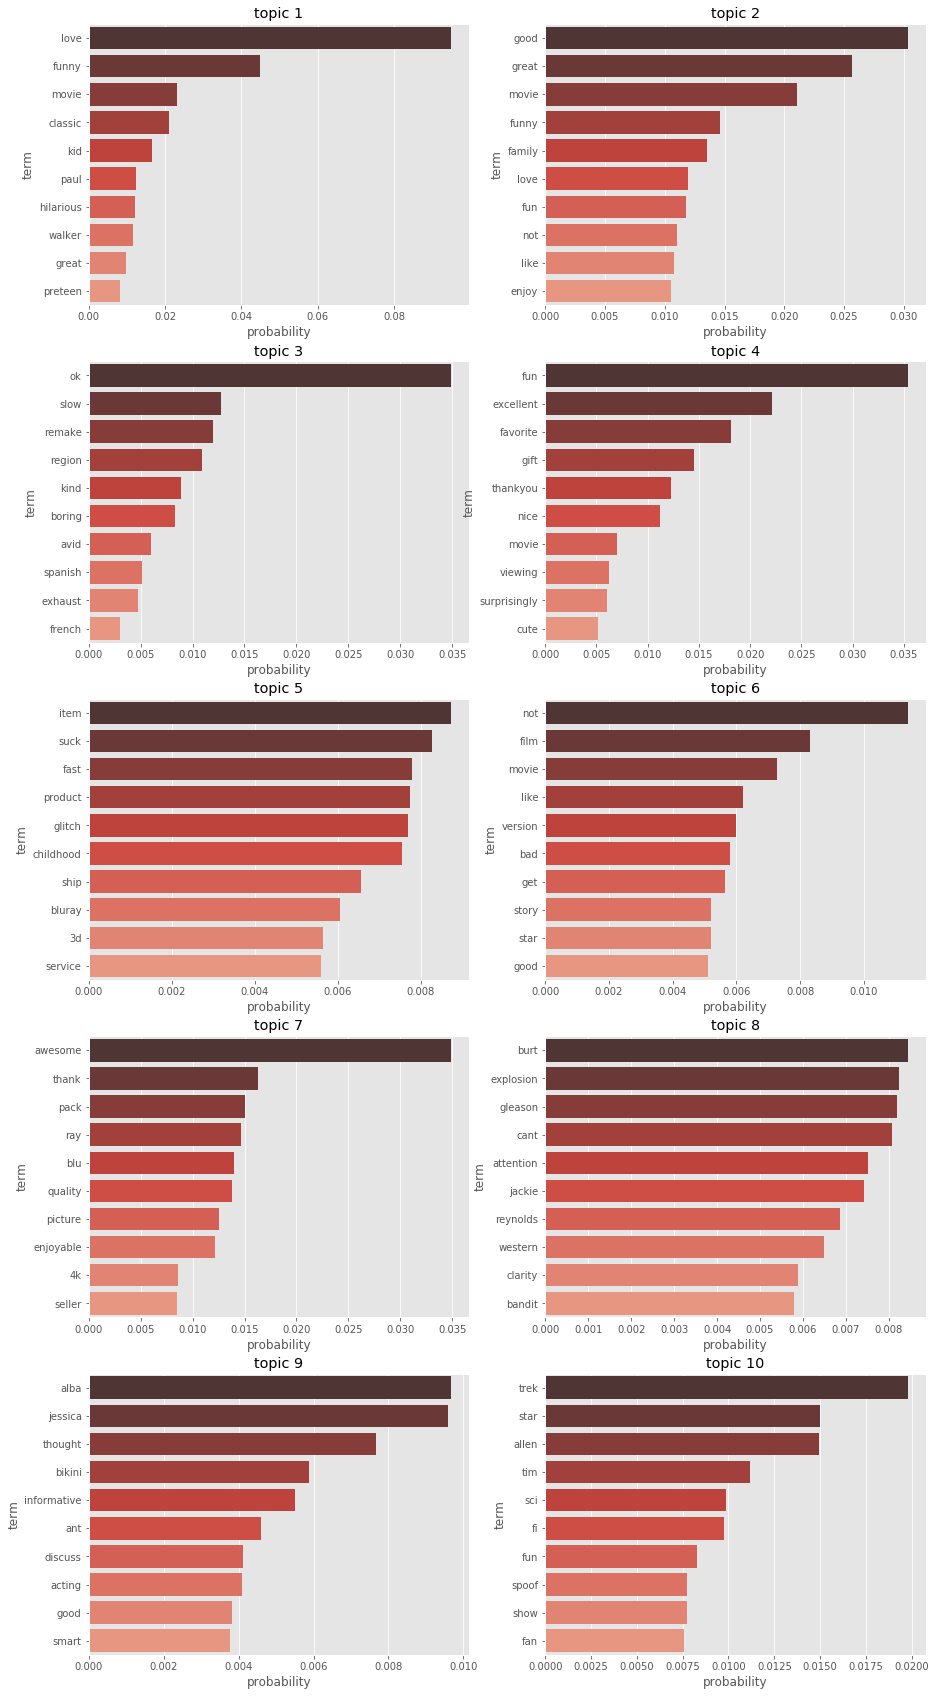

In [541]:
fiz=plt.figure(figsize=(15,30))
for i in range(10):
    df=pd.DataFrame(lda.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
    
plt.show()

<a id="resultFinal"></a>
 # IV. Summary of The Results:
 
        1) Topics 1, 2, and 3 are more frequent in the corpus.   These seem to be positive reviews.
        2) Topics 1&3 are closest together and seem to  be more similar while topics 1&6 and 4&7 are farther apart, or less similar. This makes sense since 4 may be about “Into the Blue”, 7 seems to be about romantic movies. 1 has higher frequency of positive words, 6 has the most negative words frequency. 
        3) The most representative words for all frequent topics include: fun, good, great, family, entertaining  most of reviews are positive reviews and most of movies in this category are entertaining.
        4) Topics 7-10 are less frequent in the corpus. These seem to be not very good reviews about the movies or the services with most representative words are: boring, asleep, blue ray, unnecessary. 
        5) There are more frequent positive reviews in the corpus. This is aligned with the high ratio of high rating reviews in the dataset.


 <a href="#top">Back to top</a>


<a id="ref"></a>
## V. Reference: 
    1. http://blog.conceptnet.io/posts/2012/fixing-common-unicode-mistakes-with-python-after-theyve-been-made/
    2. http://shichaoji.com/tag/topic-modeling-python-lda-visualization-gensim-pyldavis-nltk/
    3. https://pyldavis.readthedocs.io/en/latest/readme.html

 <a href="#top">Back to top</a>

### Appendix:

This topic modeling involves using statistical and mathematical modeling techniques to extract main topics from movie review corpus of documents. The emphasis is on corpus of documents because the more diverse set of documents you have, the more topics or concepts you can generate—unlike with a single document where you will not get too many topics or concepts if it talks about a singular concept. 
Topic models are also often known as probabilistic statistical models, which use specific statistical techniques including singular valued decomposition and latent dirichlet allocation to discover connected latent semantic structures in text data that yield topics and concepts. They are used extensively in text analytics and even bioinformatics.

